
Objective: Segment Equity bank customers into clusters and get profiles of each cluster.

Data:

1. Transaction
2. Demographics
3. End of day Balance
4. Loans

Steps:

1. Data cleaning
2. EDA
3. Preprocessing
4. Clustering using k-means
5. EDA to determine profiles per cluster

In [22]:
import re
import time
import sys
import os
import time
import calendar

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import islice
from configparser import ConfigParser
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

In [24]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import decomposition
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

In [26]:
import warnings
warnings.filterwarnings('ignore')

#### Loan data

In [28]:
loan_data = pd.read_csv('loans.csv', converters = {'CIF_ID': lambda x:str(x)})
loan_data.head()

,CIF_ID,FORACID,CLASSIFICATION
0,54303927515,805511328510,NORMAL
1,54300340462,315511031329,NORMAL
2,54300537728,360580815892,NORMAL
3,54304834523,410581213841,NORMAL
4,54308154918,885511195418,NORMAL


In [30]:
loan_data.isnull().sum()

CIF_ID            0
FORACID           0
CLASSIFICATION    0
dtype: int64

In [32]:
loan_data.CIF_ID.nunique()

18320

In [34]:
loan_data.shape

(25477, 3)

In [36]:
loans = loan_data.groupby(['CIF_ID', 'CLASSIFICATION']).count()
loans.head()

,,FORACID
CIF_ID,CLASSIFICATION,
54200000408,NORMAL,2
54200008143,NORMAL,2
54200009436,NORMAL,1
54200009521,NORMAL,1
54200009661,NORMAL,4


In [38]:
loans.shape

(18521, 1)

In [40]:
loan_data.CLASSIFICATION.value_counts()

NORMAL          23030
WATCH            1045
SUB-STANDARD      774
DOUBTFUL          577
LOSS               51
Name: CLASSIFICATION, dtype: int64

### EOD 

In [42]:
eod = pd.read_csv("eod_data.csv", low_memory=False, 
                     converters = {'CIF_ID': lambda x:str(x)})

In [44]:
eod = eod.drop_duplicates()

In [46]:
eod.head()

,CIF_ID,AVERAGE_MONTHLY_BALANCE,MAXIMUM_MONTHLY_BALANCE,MINIMUM_MONTHLY_BALANCE
0,54100000028,1.040000,1.04,1.04
1,54200000006,88517.198387,362933.65,3193.65
2,54200000132,10934.564516,31374.00,6.00
3,54200000408,1006.119234,14067.51,0.00
4,54200000862,364285.400968,387254.03,343964.03


In [48]:
eod.shape

(199202, 4)

In [50]:
eod.CIF_ID.nunique()

199202

In [52]:
eod.isnull().sum()

CIF_ID                     0
AVERAGE_MONTHLY_BALANCE    0
MAXIMUM_MONTHLY_BALANCE    0
MINIMUM_MONTHLY_BALANCE    0
dtype: int64

In [54]:
# fill numerical null values with 0
numerical_features = [ 'AVERAGE_MONTHLY_BALANCE', 'MAXIMUM_MONTHLY_BALANCE', 'MINIMUM_MONTHLY_BALANCE']

eod[numerical_features] = eod[numerical_features].fillna(0)

## Transactions

In [56]:
df = pd.read_csv("transactiona_data.csv", converters = {'CIF_NUM': lambda x:str(x)})

In [58]:
df['CIF_NUM'] = df["CIF_NUM"].str.slice(0, -2, 1)

In [60]:
df.rename(columns = {'CIF_NUM':'CIF_ID'}, inplace = True)

In [62]:
#df['AVG_COUNT_OF_CREDITS_8M_C'] = df['COUNT_OF_CREDITS']/8
df['AVERAGE_MONTHLY_DEBIT_COUNT'] = df['COUNT_OF_DEBITS']/8

In [64]:
df = df.drop("AVERAGE_MONTHLY_DEBIT.1", axis=1)
df = df.drop("Unnamed: 0",axis=1)

In [66]:
#df = df.drop("Unnamed: 0",axis=1, inplace = True)

In [68]:
#df[df['CIF_ID'] =='542000008']
df.CIF_ID.nunique()

153372

In [70]:
df.head()

,CIF_ID,NUMBER_OF_TRANSACTIONAL_ACCOUNTS,COUNT_OF_CREDITS,COUNT_OF_DEBITS,MAX_CREDIT_VALUE,MAX_DEBIT_VALUE,AVERAGE_MONTHLY_CREDIT,AVERAGE_MONTHLY_CREDIT_COUNT,AVERAGE_MONTHLY_DEBIT,MAX_DAY_CREDIT,MAX_DAY_DEBIT,AVERAGE_MONTHLY_DEBIT_COUNT
0,54200000006,1,14.0,25.0,343000.0,220000.0,332050.00,1.750,355150.00,2021-08-18,2021-08-28,3.125
1,54200000132,1,8.0,10.0,5613.0,5190.0,5334.75,1.000,1406.25,2021-08-24,2021-08-24,1.250
2,54200000408,1,8.0,57.0,17952.0,10000.0,17063.00,1.000,15873.75,2021-08-24,2021-08-30,7.125
3,54200000862,1,8.0,8.0,5820.0,120.0,5531.25,1.000,120.00,2021-08-24,2021-08-24,1.000
4,54200000876,2,3.0,3.0,14000.0,30000.0,4000.00,0.375,6500.00,2021-08-18,2021-07-19,0.375


In [72]:
df.shape

(153372, 12)

In [74]:
df.isnull().sum()
#df.head()

CIF_ID                              0
NUMBER_OF_TRANSACTIONAL_ACCOUNTS    0
COUNT_OF_CREDITS                    0
COUNT_OF_DEBITS                     0
MAX_CREDIT_VALUE                    0
MAX_DEBIT_VALUE                     0
AVERAGE_MONTHLY_CREDIT              0
AVERAGE_MONTHLY_CREDIT_COUNT        0
AVERAGE_MONTHLY_DEBIT               0
MAX_DAY_CREDIT                      0
MAX_DAY_DEBIT                       0
AVERAGE_MONTHLY_DEBIT_COUNT         0
dtype: int64

In [76]:
# fill numerical null values with 0
numerical_features = [ 'NUMBER_OF_TRANSACTIONAL_ACCOUNTS','COUNT_OF_CREDITS','COUNT_OF_DEBITS','MAX_CREDIT_VALUE','MAX_DEBIT_VALUE',
                      'AVERAGE_MONTHLY_CREDIT','AVERAGE_MONTHLY_CREDIT_COUNT','AVERAGE_MONTHLY_DEBIT',
                      'MAX_DAY_CREDIT','MAX_DAY_DEBIT',
'AVERAGE_MONTHLY_DEBIT_COUNT']
      

df[numerical_features] = df[numerical_features].fillna(0)

## Demographic data

In [78]:
demo_summary = pd.read_csv("demographics.csv", converters = {'CIF_ID': lambda x:str(x)})
demo_summary.head()

,CIF_ID,SOL_ID,SALUTATION,GENDER,OCCUPATION,SEGMENTATION_CLASS,REGION,CITY,SECTOR,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,HAS_CARD
0,54200054734,002,MR,M,NaN,RETAIL,NAI,223,TRADE,56,192.0,Yes
1,54200109824,017,MR,M,BNESS,RETAIL,NAI,223,CONS,40,192.0,Yes
2,54200120145,009,MR,M,OTH,RETAIL,CEN,283,F,51,192.0,Yes
3,54200134805,009,MR,M,NaN,RETAIL,CEN,283,NaN,63,192.0,Yes
4,54200139749,009,MR,M,OTH,RETAIL,CEN,495,DAIMA,56,192.0,No


In [80]:
#demo_summary['CIF_ID'] = demo_summary['CIF_ID'].astype(str)
demo_summary.REGION.nunique()

70

In [82]:
demo_summary = demo_summary.drop_duplicates()

In [84]:
demo_summary.CIF_ID.nunique()

200000

In [86]:
demo = demo_summary[demo_summary['NUMBER_OF_MONTHS_SINCE_OPEN']>0].reset_index(drop=True)
len(demo)

186426

In [88]:
demo.isnull().sum()

CIF_ID                             0
SOL_ID                             0
SALUTATION                         0
GENDER                          8902
OCCUPATION                     36576
SEGMENTATION_CLASS               194
REGION                         12083
CITY                              26
SECTOR                         88296
AGE                                0
NUMBER_OF_MONTHS_SINCE_OPEN        0
HAS_CARD                           0
dtype: int64

In [90]:
demo[demo['CIF_ID'] =='54304198870']

,CIF_ID,SOL_ID,SALUTATION,GENDER,OCCUPATION,SEGMENTATION_CLASS,REGION,CITY,SECTOR,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,HAS_CARD
250,54304198870,029,MR,M,TEACH,RETAIL,NYA,988,NaN,49,144.0,No


In [92]:
demo['REGION'].fillna('UNKNOWN', inplace=True)

In [94]:
# Region
region=['RIF', 'CEN',  'NAI', 'EAS','NYA','WES', 'COA', 'NOR', 'UNKNOWN']
demo.loc[~demo['REGION'].isin(region),'REGION'] = 'OTHER'

In [96]:
# segmentation class
seg_class=['RETAIL', 'BUSINESS', 'AGRIC', 'MICRO', 'CONSM','CORPT','SME', 'INSTIT', 'PUBLI']
demo.loc[~demo['SEGMENTATION_CLASS'].isin(seg_class),'SEGMENTATION_CLASS'] = 'OTHERS'

In [98]:
#Gender
demo['GENDER'] =  demo['GENDER'].str.upper()
demo.loc[~demo['GENDER'].isin(['F','M']), 'GENDER'] = 'UNKNOWN'

In [100]:
# Occupation
occ_class=['TECH','STUD','FARM', 'BNESS']
demo['OCCUPATION'].unique()
demo.loc[~demo['OCCUPATION'].isin(occ_class),'OCCUPATION']='OTHERS'

In [102]:
#Dropping Sector and City columns
demo.drop(['SECTOR', 'CITY'], axis=1, inplace=True)

In [104]:
demo.dtypes

CIF_ID                          object
SOL_ID                          object
SALUTATION                      object
GENDER                          object
OCCUPATION                      object
SEGMENTATION_CLASS              object
REGION                          object
AGE                              int64
NUMBER_OF_MONTHS_SINCE_OPEN    float64
HAS_CARD                        object
dtype: object

In [106]:
demo.loc[demo['AGE'] <= 0, 'AGE'] = 39

In [108]:
demo.isnull().sum()

CIF_ID                         0
SOL_ID                         0
SALUTATION                     0
GENDER                         0
OCCUPATION                     0
SEGMENTATION_CLASS             0
REGION                         0
AGE                            0
NUMBER_OF_MONTHS_SINCE_OPEN    0
HAS_CARD                       0
dtype: int64

In [110]:
# fill numerical null values with 0
numerical_features = ['NUMBER_OF_MONTHS_SINCE_OPEN', 'AGE']
      

demo[numerical_features] = demo[numerical_features].fillna(0)

In [112]:
demo.head()

,CIF_ID,SOL_ID,SALUTATION,GENDER,OCCUPATION,SEGMENTATION_CLASS,REGION,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,HAS_CARD
0,54200054734,002,MR,M,OTHERS,RETAIL,NAI,56,192.00,Yes
1,54200109824,017,MR,M,BNESS,RETAIL,NAI,40,192.00,Yes
2,54200120145,009,MR,M,OTHERS,RETAIL,CEN,51,192.00,Yes
3,54200134805,009,MR,M,OTHERS,RETAIL,CEN,63,192.00,Yes
4,54200139749,009,MR,M,OTHERS,RETAIL,CEN,56,192.00,No


## Merging the datasets

In [114]:
data  = pd.merge(demo, df, on='CIF_ID', how='left')
data  = pd.merge(data, eod, on='CIF_ID', how='left')

In [116]:
data.loc[data['CIF_ID'].isin(loan_data['CIF_ID']), 'HAS_LOAN'] = 'Yes'
data['HAS_LOAN'].fillna('No', inplace=True)

In [117]:
data.head()

,CIF_ID,SOL_ID,SALUTATION,GENDER,OCCUPATION,SEGMENTATION_CLASS,REGION,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,HAS_CARD,...,AVERAGE_MONTHLY_CREDIT,AVERAGE_MONTHLY_CREDIT_COUNT,AVERAGE_MONTHLY_DEBIT,MAX_DAY_CREDIT,MAX_DAY_DEBIT,AVERAGE_MONTHLY_DEBIT_COUNT,AVERAGE_MONTHLY_BALANCE,MAXIMUM_MONTHLY_BALANCE,MINIMUM_MONTHLY_BALANCE,HAS_LOAN
0,54200054734,002,MR,M,OTHERS,RETAIL,NAI,56,192.00,Yes,...,302.57,0.38,7017.50,2021-03-23,2021-07-26,2.50,5738.28,51118.39,1.44,No
1,54200109824,017,MR,M,BNESS,RETAIL,NAI,40,192.00,Yes,...,89193.75,4.25,255162.75,2021-08-17,2021-08-27,70.00,445840.18,899114.87,914.87,No
2,54200120145,009,MR,M,OTHERS,RETAIL,CEN,51,192.00,Yes,...,36736.57,1.62,53127.24,2021-07-29,2021-08-17,5.75,10455.89,173525.57,6.22,No
3,54200134805,009,MR,M,OTHERS,RETAIL,CEN,63,192.00,Yes,...,2677.85,0.50,10175.00,2021-08-30,2021-08-06,1.88,6813.35,32469.51,93.31,No
4,54200139749,009,MR,M,OTHERS,RETAIL,CEN,56,192.00,No,...,nan,nan,nan,NaN,NaN,nan,53.15,53.15,53.15,No


In [118]:
data.isna().sum()

CIF_ID                                  0
SOL_ID                                  0
SALUTATION                              0
GENDER                                  0
OCCUPATION                              0
SEGMENTATION_CLASS                      0
REGION                                  0
AGE                                     0
NUMBER_OF_MONTHS_SINCE_OPEN             0
HAS_CARD                                0
NUMBER_OF_TRANSACTIONAL_ACCOUNTS    43013
COUNT_OF_CREDITS                    43013
COUNT_OF_DEBITS                     43013
MAX_CREDIT_VALUE                    43013
MAX_DEBIT_VALUE                     43013
AVERAGE_MONTHLY_CREDIT              43013
AVERAGE_MONTHLY_CREDIT_COUNT        43013
AVERAGE_MONTHLY_DEBIT               43013
MAX_DAY_CREDIT                      43013
MAX_DAY_DEBIT                       43013
AVERAGE_MONTHLY_DEBIT_COUNT         43013
AVERAGE_MONTHLY_BALANCE               149
MAXIMUM_MONTHLY_BALANCE               149
MINIMUM_MONTHLY_BALANCE           

In [119]:
data.describe()

,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,NUMBER_OF_TRANSACTIONAL_ACCOUNTS,COUNT_OF_CREDITS,COUNT_OF_DEBITS,MAX_CREDIT_VALUE,MAX_DEBIT_VALUE,AVERAGE_MONTHLY_CREDIT,AVERAGE_MONTHLY_CREDIT_COUNT,AVERAGE_MONTHLY_DEBIT,AVERAGE_MONTHLY_DEBIT_COUNT,AVERAGE_MONTHLY_BALANCE,MAXIMUM_MONTHLY_BALANCE,MINIMUM_MONTHLY_BALANCE
count,186426.00,186426.00,143413.00,143413.00,143413.00,143413.00,143413.00,143413.00,143413.00,143413.00,143413.00,186277.00,186277.00,186277.00
mean,37.60,97.71,1.10,40.55,50.90,98159.45,93503.89,148297.92,5.07,139838.09,6.36,51213.56,152704.30,18661.47
std,13.73,54.14,0.45,733.90,224.39,2987103.64,3003740.71,4201268.39,91.74,4146777.99,28.05,747407.07,2607610.20,475933.35
min,1.00,12.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-48706665.39,-23209586.56,-94496440.95
25%,28.00,48.00,1.00,3.00,3.00,5386.00,5400.00,1741.12,0.38,2025.00,0.38,161.29,801.00,0.00
50%,37.00,96.00,1.00,5.00,12.00,10837.00,10280.00,4638.75,0.62,5931.25,1.50,1034.76,10009.92,25.02
75%,46.00,144.00,1.00,14.00,44.00,36270.00,31000.00,21127.47,1.75,24930.38,5.50,10102.47,50372.75,359.45
max,71.00,720.00,40.00,240510.00,35907.00,900000000.00,920016986.30,936146833.60,30063.75,928032670.07,4488.38,126370308.19,678410566.35,63623900.35


In [120]:
#data.loc[data['NUMBER_OF_TRANSACTIONAL_ACCOUNTS'] == 'Nan', 'NUMBER_OF_TRANSACTIONAL_ACCOUNTS'] = 1.00, inplace=True
data.loc[np.isnan(data["NUMBER_OF_TRANSACTIONAL_ACCOUNTS"]), 'NUMBER_OF_TRANSACTIONAL_ACCOUNTS'] = 1.00
data.loc[np.isnan(data["COUNT_OF_CREDITS"]), 'COUNT_OF_CREDITS'] = 40.55
data.loc[np.isnan(data["COUNT_OF_DEBITS"]), 'COUNT_OF_DEBITS'] = 50.90
data.loc[np.isnan(data["MAX_CREDIT_VALUE"]), 'MAX_CREDIT_VALUE'] = 98159.45
data.loc[np.isnan(data["MAX_DEBIT_VALUE"]), 'MAX_DEBIT_VALUE'] = 93503.89
data.loc[np.isnan(data["AVERAGE_MONTHLY_CREDIT"]), 'AVERAGE_MONTHLY_CREDIT'] = 148297.92
data.loc[np.isnan(data["AVERAGE_MONTHLY_CREDIT_COUNT"]), 'AVERAGE_MONTHLY_CREDIT_COUNT'] = 5.07
data.loc[np.isnan(data["AVERAGE_MONTHLY_DEBIT"]), 'AVERAGE_MONTHLY_DEBIT'] = 139838.09
data.loc[np.isnan(data["AVERAGE_MONTHLY_DEBIT_COUNT"]), 'AVERAGE_MONTHLY_DEBIT_COUNT'] = 6.36
data.loc[np.isnan(data["AVERAGE_MONTHLY_BALANCE"]), 'AVERAGE_MONTHLY_BALANCE'] = 51213.56
data.loc[np.isnan(data["MINIMUM_MONTHLY_BALANCE"]), 'MINIMUM_MONTHLY_BALANCE'] = 18661.47
data.loc[np.isnan(data["MAXIMUM_MONTHLY_BALANCE"]), 'MAXIMUM_MONTHLY_BALANCE'] = 152704.30

In [121]:
data.isna().sum()

CIF_ID                                  0
SOL_ID                                  0
SALUTATION                              0
GENDER                                  0
OCCUPATION                              0
SEGMENTATION_CLASS                      0
REGION                                  0
AGE                                     0
NUMBER_OF_MONTHS_SINCE_OPEN             0
HAS_CARD                                0
NUMBER_OF_TRANSACTIONAL_ACCOUNTS        0
COUNT_OF_CREDITS                        0
COUNT_OF_DEBITS                         0
MAX_CREDIT_VALUE                        0
MAX_DEBIT_VALUE                         0
AVERAGE_MONTHLY_CREDIT                  0
AVERAGE_MONTHLY_CREDIT_COUNT            0
AVERAGE_MONTHLY_DEBIT                   0
MAX_DAY_CREDIT                      43013
MAX_DAY_DEBIT                       43013
AVERAGE_MONTHLY_DEBIT_COUNT             0
AVERAGE_MONTHLY_BALANCE                 0
MAXIMUM_MONTHLY_BALANCE                 0
MINIMUM_MONTHLY_BALANCE           

In [122]:
data.head()

,CIF_ID,SOL_ID,SALUTATION,GENDER,OCCUPATION,SEGMENTATION_CLASS,REGION,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,HAS_CARD,...,AVERAGE_MONTHLY_CREDIT,AVERAGE_MONTHLY_CREDIT_COUNT,AVERAGE_MONTHLY_DEBIT,MAX_DAY_CREDIT,MAX_DAY_DEBIT,AVERAGE_MONTHLY_DEBIT_COUNT,AVERAGE_MONTHLY_BALANCE,MAXIMUM_MONTHLY_BALANCE,MINIMUM_MONTHLY_BALANCE,HAS_LOAN
0,54200054734,002,MR,M,OTHERS,RETAIL,NAI,56,192.00,Yes,...,302.57,0.38,7017.50,2021-03-23,2021-07-26,2.50,5738.28,51118.39,1.44,No
1,54200109824,017,MR,M,BNESS,RETAIL,NAI,40,192.00,Yes,...,89193.75,4.25,255162.75,2021-08-17,2021-08-27,70.00,445840.18,899114.87,914.87,No
2,54200120145,009,MR,M,OTHERS,RETAIL,CEN,51,192.00,Yes,...,36736.57,1.62,53127.24,2021-07-29,2021-08-17,5.75,10455.89,173525.57,6.22,No
3,54200134805,009,MR,M,OTHERS,RETAIL,CEN,63,192.00,Yes,...,2677.85,0.50,10175.00,2021-08-30,2021-08-06,1.88,6813.35,32469.51,93.31,No
4,54200139749,009,MR,M,OTHERS,RETAIL,CEN,56,192.00,No,...,148297.92,5.07,139838.09,NaN,NaN,6.36,53.15,53.15,53.15,No


In [123]:
#Remove constant features:This is because features with single unique values do not help the model generalize well as they have variance/standard deviation of 0
def find_constant_features(dataFrame):
    constant = []
    for column in list(dataFrame.columns):
        if dataFrame[column].unique().size < 2:
            constant.append(column)
    return constant
constant = find_constant_features(data)
print(constant)
data.drop(constant, axis =1, inplace = True)
data.shape

[]


(186426, 25)

# E.D.A

In [124]:
pd.options.display.float_format = '{:.2f}'.format
data.describe()

,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,NUMBER_OF_TRANSACTIONAL_ACCOUNTS,COUNT_OF_CREDITS,COUNT_OF_DEBITS,MAX_CREDIT_VALUE,MAX_DEBIT_VALUE,AVERAGE_MONTHLY_CREDIT,AVERAGE_MONTHLY_CREDIT_COUNT,AVERAGE_MONTHLY_DEBIT,AVERAGE_MONTHLY_DEBIT_COUNT,AVERAGE_MONTHLY_BALANCE,MAXIMUM_MONTHLY_BALANCE,MINIMUM_MONTHLY_BALANCE
count,186426.00,186426.00,186426.00,186426.00,186426.00,186426.00,186426.00,186426.00,186426.00,186426.00,186426.00,186426.00,186426.00,186426.00
mean,37.60,97.71,1.08,40.55,50.90,98159.45,93503.89,148297.92,5.07,139838.09,6.36,51213.56,152704.30,18661.47
std,13.73,54.14,0.39,643.69,196.81,2619937.69,2634529.78,3684860.89,80.46,3637068.28,24.60,747108.33,2606567.93,475743.12
min,1.00,12.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-48706665.39,-23209586.56,-94496440.95
25%,28.00,48.00,1.00,3.00,4.00,8000.00,8000.00,2500.00,0.38,2500.00,0.50,161.29,806.33,0.00
50%,37.00,96.00,1.00,9.00,26.00,21000.00,20000.00,11904.31,1.12,14230.62,3.25,1038.62,10021.15,25.20
75%,46.00,144.00,1.00,40.55,50.90,98159.45,93503.89,148297.92,5.07,139838.09,6.36,10162.23,50513.89,363.00
max,71.00,720.00,40.00,240510.00,35907.00,900000000.00,920016986.30,936146833.60,30063.75,928032670.07,4488.38,126370308.19,678410566.35,63623900.35


In [125]:
data.OCCUPATION.value_counts()/len(data)

OTHERS   0.54
TECH     0.14
FARM     0.13
BNESS    0.12
STUD     0.07
Name: OCCUPATION, dtype: float64

In [126]:
data.SEGMENTATION_CLASS.value_counts()/len(data)

RETAIL     0.72
MICRO      0.11
CONSM      0.09
BUSINESS   0.05
AGRIC      0.02
SME        0.00
CORPT      0.00
INSTIT     0.00
OTHERS     0.00
PUBLI      0.00
Name: SEGMENTATION_CLASS, dtype: float64

In [127]:
data.HAS_LOAN.value_counts()#/len(data)

No     168234
Yes     18192
Name: HAS_LOAN, dtype: int64

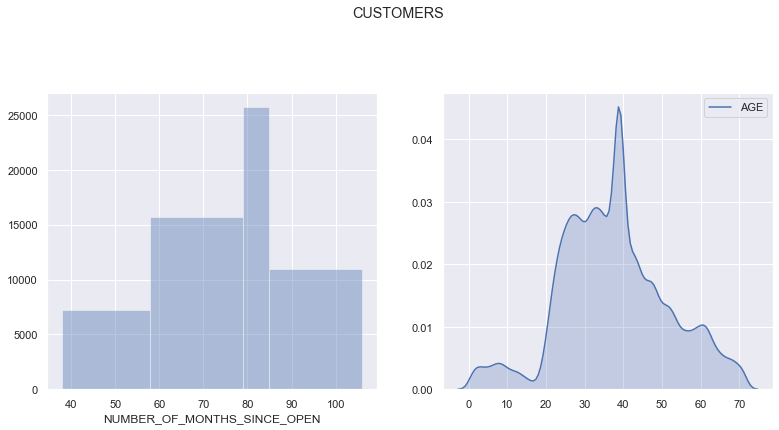

In [128]:
x=data['NUMBER_OF_MONTHS_SINCE_OPEN']
y=data['AGE']
sns.set(rc={"figure.figsize": (13, 12)})
plt.subplot(2,2,1)
ax = sns.distplot(x,kde=False,bins=[38,58,79,85,106])
#plt.xlim(0,150)
# plt.title('CUSTOMERS')
plt.subplot(2,2,2)
ax = sns.kdeplot(y,shade=True)
plt.suptitle('CUSTOMERS')
plt.show()

In [129]:
# Creating bins for AGE
def age_bins(data):
    if data['AGE'] < 12:
        return 'a<13'
    elif (data['AGE'] >12) & (data['AGE'] <= 17):
        return 'b13-17'
    elif (data['AGE'] > 17) & (data['AGE'] <= 24):
        return 'c18-24'
    elif (data['AGE'] > 24) & (data['AGE'] <= 35):
        return 'd25-35'
    elif (data['AGE'] > 35) & (data['AGE'] <= 45):
        return 'e36-45'
    elif (data['AGE'] > 45) & (data['AGE'] <= 55):
        return 'f46-55'
    elif (data['AGE'] > 55) & (data['AGE'] <= 65):
        return 'g56-65'
    elif data['AGE'] > 65:
        return 'h65+'
    
data['AGE_BINS'] = data.apply(lambda AGE:age_bins(AGE), axis = 1)


Text(0.5, 1.0, 'Age Distribution')

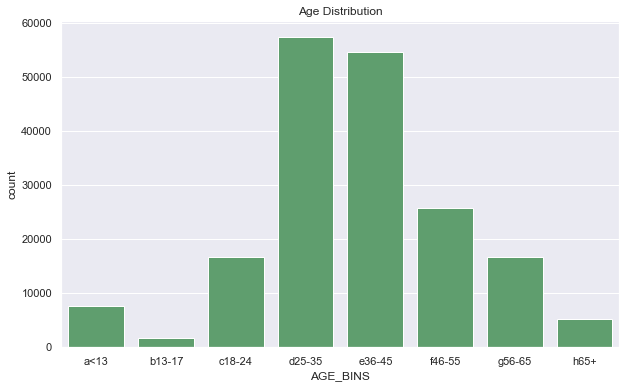

In [130]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'AGE_BINS', data = data.sort_values(by='AGE_BINS'),
             color = 'g'
             )
plt.title('Age Distribution')

In [131]:
data['NUMBER_OF_MONTHS_SINCE_OPEN'].describe()

count   186426.00
mean        97.71
std         54.14
min         12.00
25%         48.00
50%         96.00
75%        144.00
max        720.00
Name: NUMBER_OF_MONTHS_SINCE_OPEN, dtype: float64

In [132]:
data = data[data['NUMBER_OF_MONTHS_SINCE_OPEN']<=192].reset_index(drop=True)

In [133]:
data['NUMBER_OF_MONTHS_SINCE_OPEN'].quantile(0.99)

192.0

In [134]:
data['CUSTOMER_TENURE_BINS'] = pd.qcut(data['NUMBER_OF_MONTHS_SINCE_OPEN'], 7)

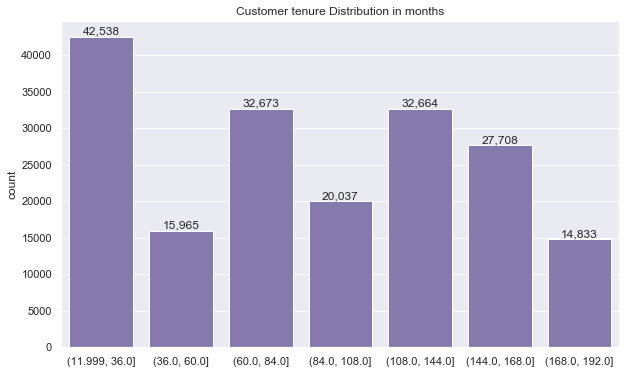

In [135]:
plt.figure(figsize = (10,6))
splot = sns.countplot(x = 'CUSTOMER_TENURE_BINS', data = data.sort_values(by='CUSTOMER_TENURE_BINS'),
             color = 'm')

plt.title('Customer tenure Distribution in months')

sns.set(font_scale=1.0)
splot.set(xlabel=None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ','),
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 5), textcoords = 'offset points')

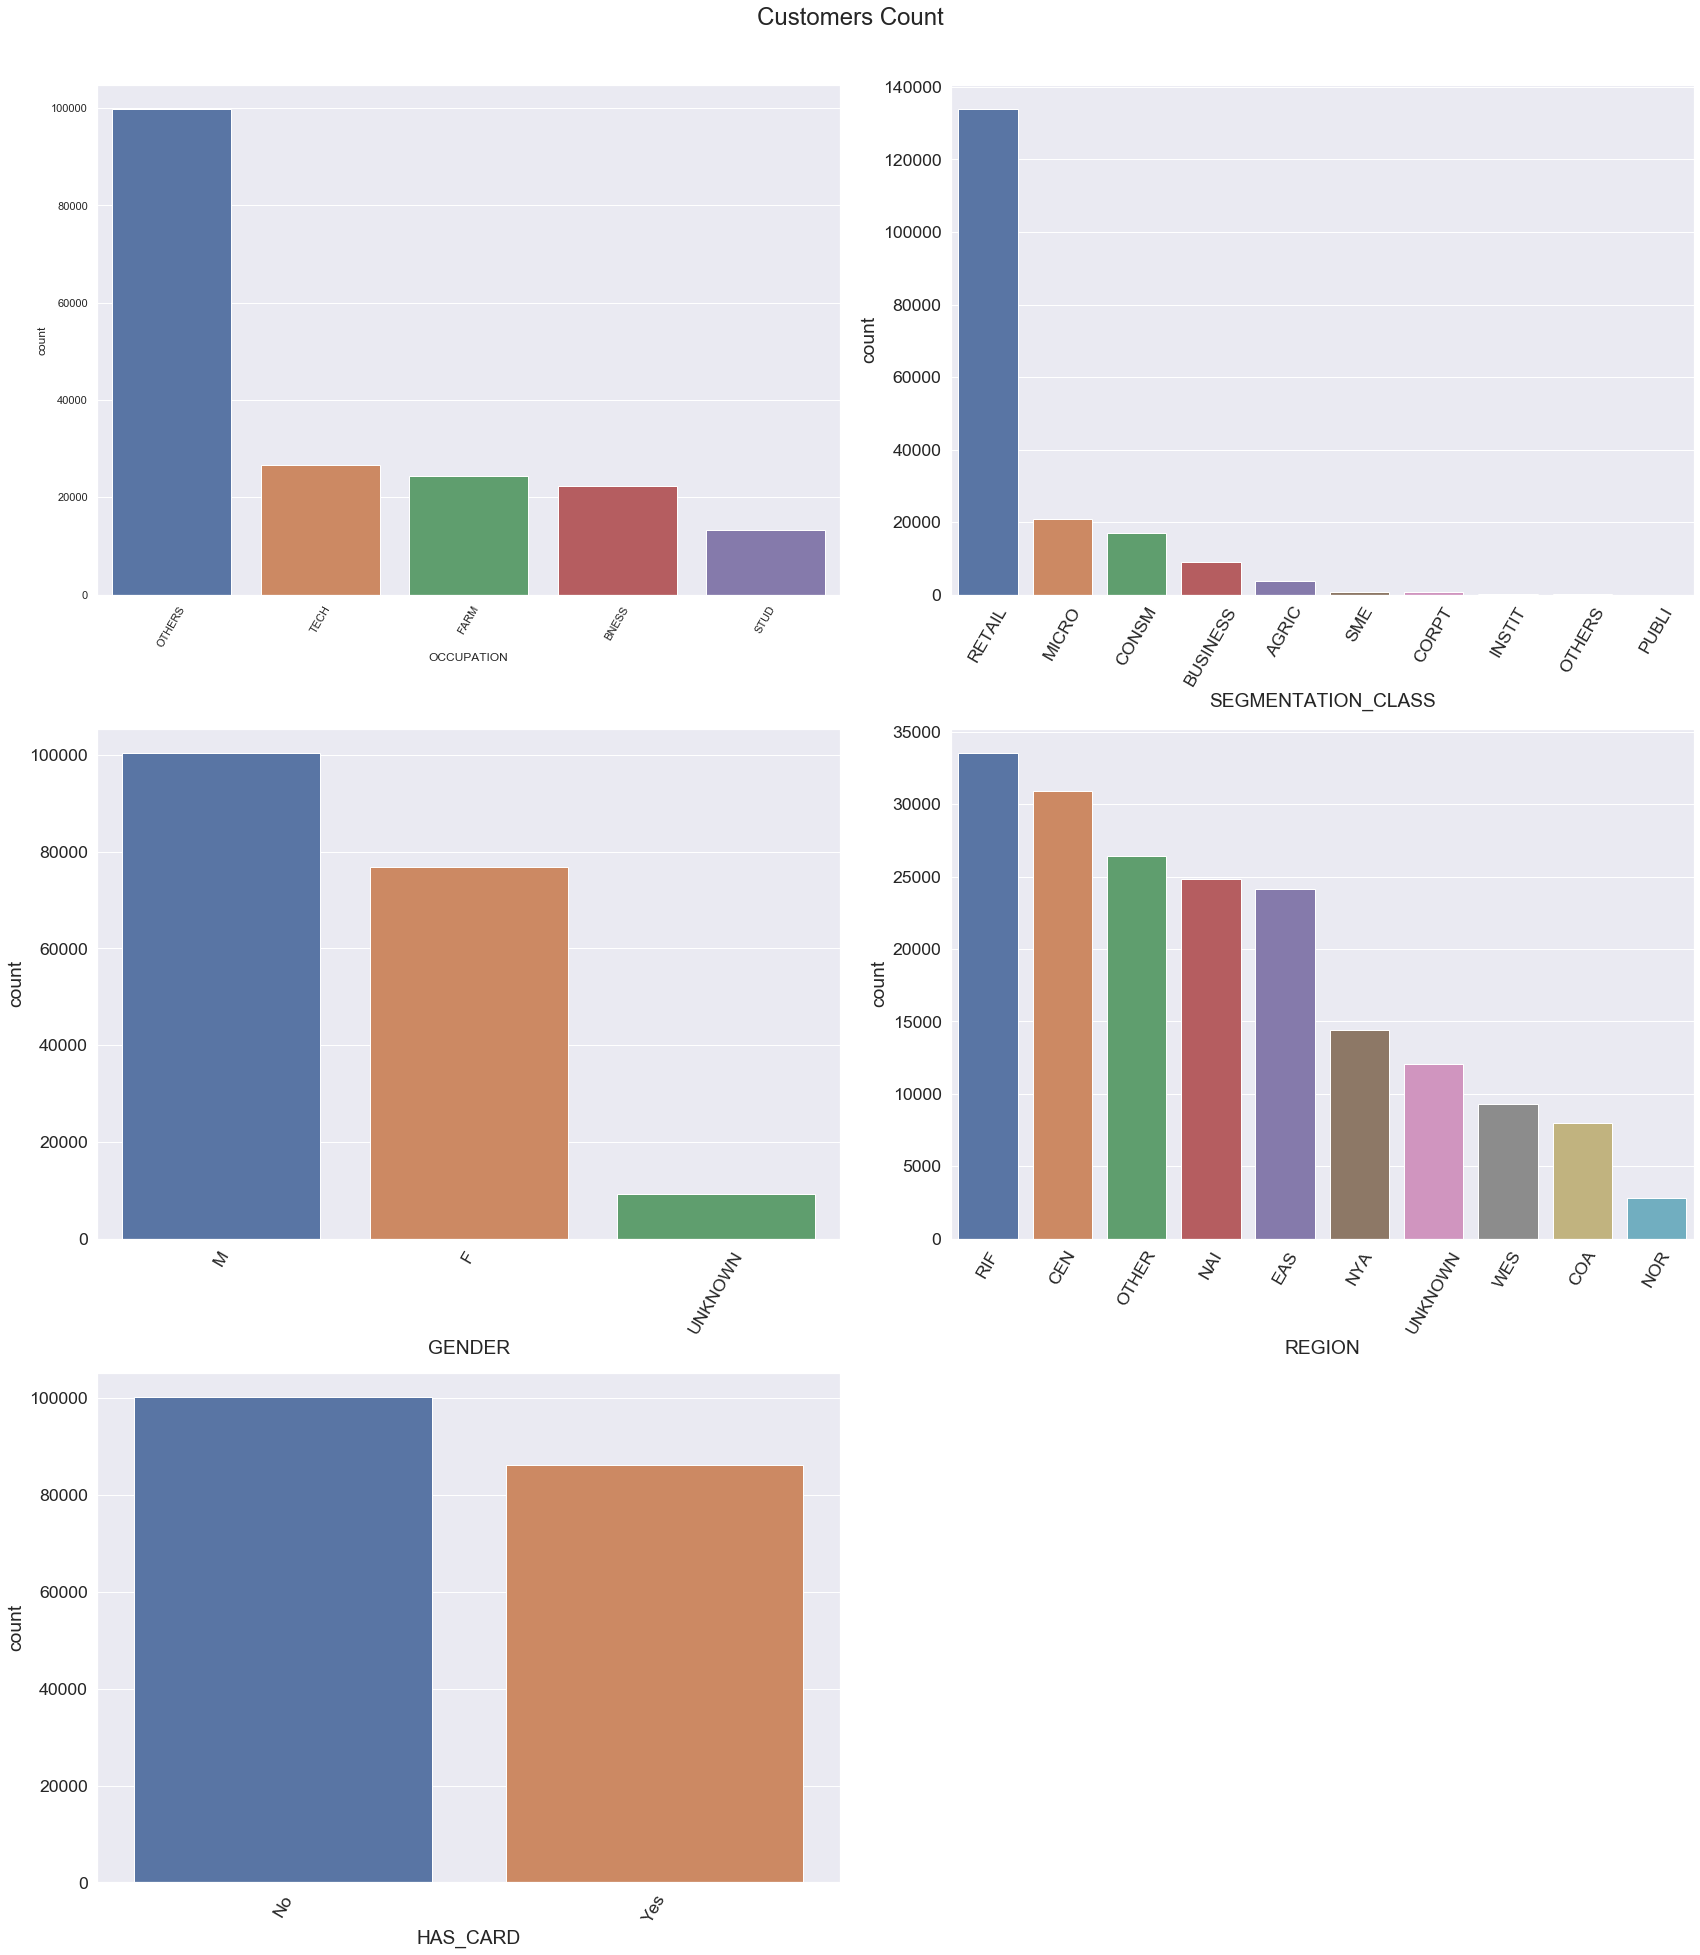

In [136]:
features=['OCCUPATION', 'SEGMENTATION_CLASS','GENDER','REGION', 'HAS_CARD']
fig=plt.subplots(figsize=(24,36))

for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j, data = data, order = data[j].value_counts().index)
    sns.set(font_scale=1.6)
    plt.xticks(rotation=60)
#     plt.title("EGF_CUSTOMERS")
# sns.set(font_scale=1.6)
plt.tight_layout()
plt.suptitle("Customers Count", size=24)
plt.subplots_adjust(top=0.95)

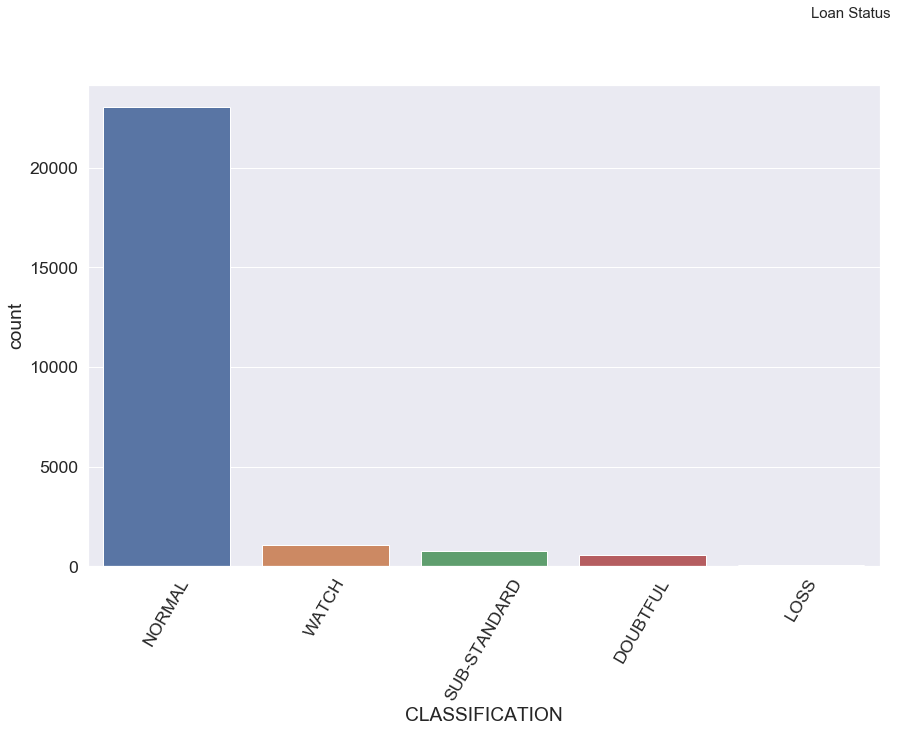

In [137]:
features=['CLASSIFICATION']
fig=plt.subplots(figsize=(24,36))

for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j, data = loan_data, order = loan_data[j].value_counts().index)
    sns.set(font_scale=1.6)
    plt.xticks(rotation=60)
plt.tight_layout()
plt.suptitle("Loan Status", size=15)
plt.subplots_adjust(top=0.95)

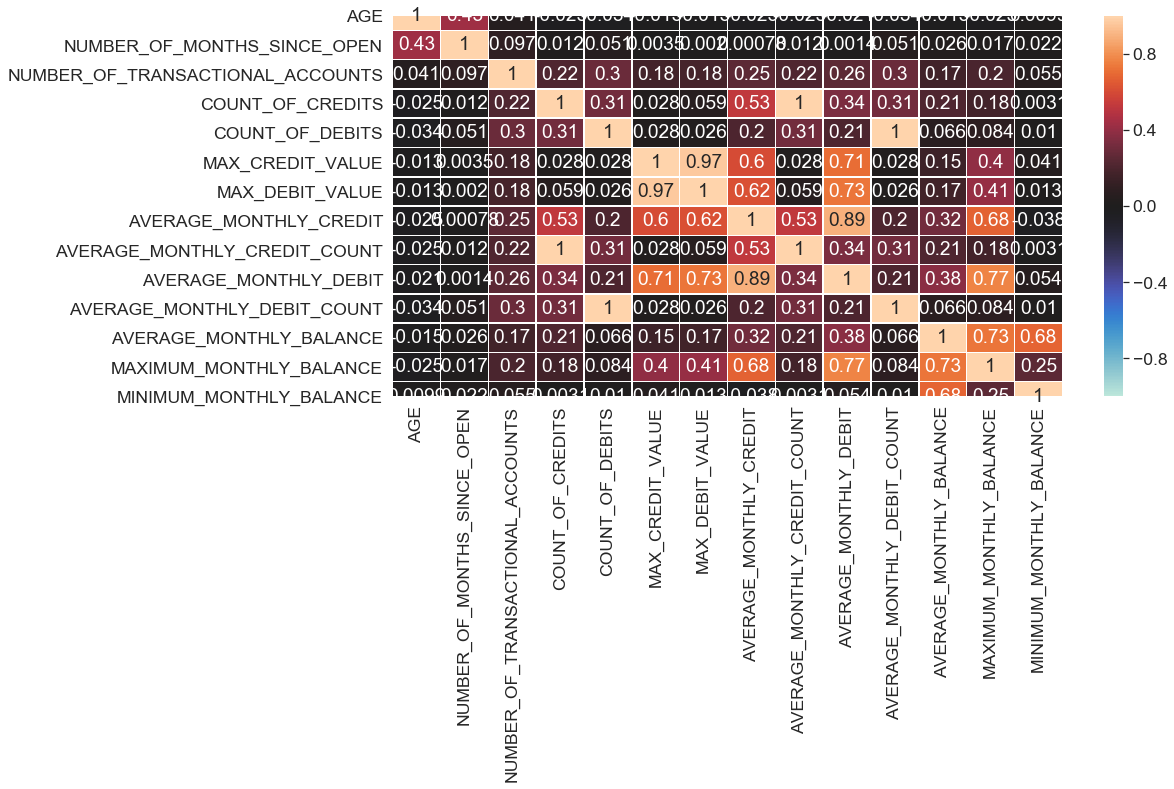

In [138]:
all_col = data.iloc[:,1:].columns.tolist()
plt.figure(figsize=(15,7))
sns.heatmap(data[all_col].corr(),
            annot=True,
            linewidths=0.5,vmin=-1,vmax=1,
            center=0,
            cbar=True,)
plt.show()

### Pre-processing

In [139]:
len(data)

186418

In [140]:
data.CIF_ID.nunique()

186418

In [141]:
numerical_features = ['AVERAGE_MONTHLY_BALANCE', 'MAXIMUM_MONTHLY_BALANCE', 'MINIMUM_MONTHLY_BALANCE', 
                      'NUMBER_OF_TRANSACTIONAL_ACCOUNTS', 'COUNT_OF_CREDITS', 'COUNT_OF_DEBITS','MAX_CREDIT_VALUE',
                      'MAX_DEBIT_VALUE', 'AVERAGE_MONTHLY_CREDIT','AVERAGE_MONTHLY_CREDIT_COUNT','AVERAGE_MONTHLY_DEBIT',
                      'MAX_DAY_CREDIT','MAX_DAY_DEBIT','AVERAGE_MONTHLY_DEBIT_COUNT', 'NUMBER_OF_MONTHS_SINCE_OPEN', 'AGE']

In [142]:
cat_features = ['OCCUPATION', 'SEGMENTATION_CLASS', 'GENDER', 'REGION', 'AGE_BINS', 'HAS_CARD', 'CUSTOMER_TENURE_BINS', 'HAS_LOAN']


In [143]:
features = data.copy()

In [144]:
data.AGE_BINS.unique()

array(['g56-65', 'e36-45', 'f46-55', 'h65+', 'b13-17', 'd25-35', 'a<13',
       'c18-24', None], dtype=object)

#### Encoding categorical features

In [145]:
#casting the columns into strings
labelencoder = LabelEncoder()

#features[cat_features] = features[cat_features].apply(LabelEncoder().fit_transform)
features[cat_features] = features[cat_features].apply(lambda col: LabelEncoder().fit_transform(col.astype(str)), axis=0, result_type='expand')

#### Scaling data

In [146]:
input_features = numerical_features + cat_features

In [147]:
input_features = ['OCCUPATION', 'SEGMENTATION_CLASS', 'GENDER', 'HAS_CARD', 'HAS_LOAN',
       'REGION', 'AGE_BINS', 'AVERAGE_MONTHLY_BALANCE', 'MAXIMUM_MONTHLY_BALANCE', 'MINIMUM_MONTHLY_BALANCE', 
                      'NUMBER_OF_TRANSACTIONAL_ACCOUNTS', 'COUNT_OF_CREDITS', 'COUNT_OF_DEBITS']

print('input_features:', len(input_features))

input_features: 13


In [148]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(features[input_features])

### PCA

In [149]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [150]:
pca = decomposition.PCA()

x_reduced = pca.fit_transform(x_scaled) 
pca.explained_variance_ 

array([2.31, 1.65, 1.49, 1.34, 0.99, 0.88, 0.80, 0.76, 0.75, 0.70, 0.61,
       0.59, 0.11])

In [188]:
model = pca.fit(pd.DataFrame(x_reduced))
n_pcs = model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = list(features[input_features].columns)

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_imp = pd.DataFrame(dic.items())
#df_imp.columns = ['IMPORTANCE', 'FEATURES']
# df_imp['IMPORTANCE'] = most_important
#df_imp

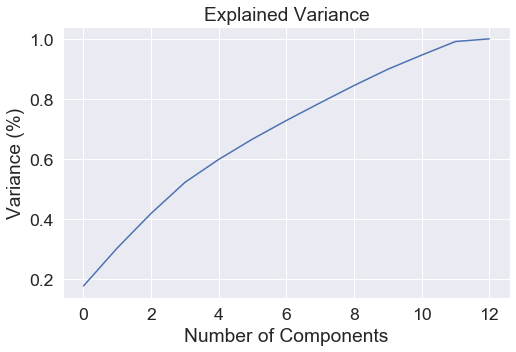

In [189]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()


In [153]:
x_scaled.shape

(186418, 13)

In [154]:
import scipy.stats as stats
X_scaled = stats.zscore(x_scaled)
#X_scaled

In [155]:
pca = decomposition.PCA(n_components=13)
x_reduced = pca.fit_transform(X_scaled)

In [156]:
x_reduced.shape

(186418, 13)

In [157]:
X_reduced = stats.zscore(x_reduced)

## K-means Clustering

#### Elbow method

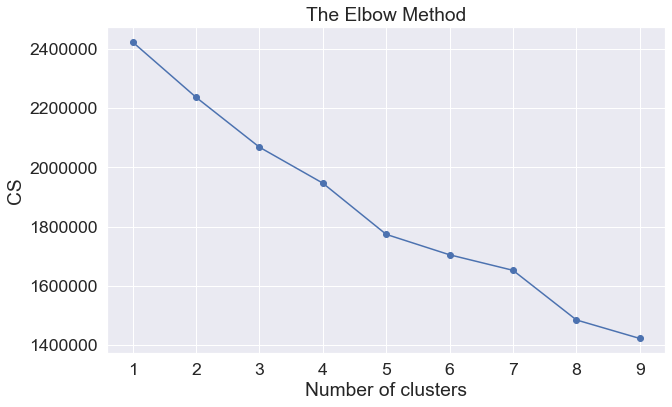

In [223]:
X = X_reduced


#sns.set(rc={"figure.figsize": (6, 8)})
plt.figure(figsize=(10,6))
cs = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 10), cs, '-o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [224]:
kmeanModel = KMeans(n_clusters=5, random_state = 0)
kmeanModel.fit_predict(x_reduced)
#print(kmeans.cluster_centers_)

array([1, 1, 1, ..., 1, 3, 1])

In [225]:
kmeanModel.inertia_

1647645.9297696433

In [226]:
kmeanModel.labels_
#print(kmeans.labels_)

array([1, 1, 1, ..., 1, 3, 1])

In [227]:
labels = kmeanModel.labels_
varieties = features['CIF_ID'].to_list()

In [228]:
np.array(np.unique(labels, return_counts=True)).T

array([[    0, 44551],
       [    1, 90475],
       [    2, 18033],
       [    3, 33342],
       [    4,    17]], dtype=int64)

In [229]:
data_cluster = pd.DataFrame({'CLUSTERS': labels, 'CIF_ID': varieties})

In [230]:
data_cluster['CLUSTERS'].value_counts().to_frame()

,CLUSTERS
1,90475
0,44551
3,33342
2,18033
4,17


In [231]:
#data_cluster['CIF_ID'].loc[data_cluster['CLUSTERS']==2].to_list()

### Cluster Profiles

In [232]:
data2 = pd.merge(data,data_cluster, on='CIF_ID')
data2.head()

,CIF_ID,SOL_ID,SALUTATION,GENDER,OCCUPATION,SEGMENTATION_CLASS,REGION,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,HAS_CARD,...,MAX_DAY_CREDIT,MAX_DAY_DEBIT,AVERAGE_MONTHLY_DEBIT_COUNT,AVERAGE_MONTHLY_BALANCE,MAXIMUM_MONTHLY_BALANCE,MINIMUM_MONTHLY_BALANCE,HAS_LOAN,AGE_BINS,CUSTOMER_TENURE_BINS,CLUSTERS
0,54200054734,002,MR,M,OTHERS,RETAIL,NAI,56,192.00,Yes,...,2021-03-23,2021-07-26,2.50,"5,738.28","51,118.39",1.44,No,g56-65,"(168.0, 192.0]",1
1,54200109824,017,MR,M,BNESS,RETAIL,NAI,40,192.00,Yes,...,2021-08-17,2021-08-27,70.00,"445,840.18","899,114.87",914.87,No,e36-45,"(168.0, 192.0]",1
2,54200120145,009,MR,M,OTHERS,RETAIL,CEN,51,192.00,Yes,...,2021-07-29,2021-08-17,5.75,"10,455.89","173,525.57",6.22,No,f46-55,"(168.0, 192.0]",1
3,54200134805,009,MR,M,OTHERS,RETAIL,CEN,63,192.00,Yes,...,2021-08-30,2021-08-06,1.88,"6,813.35","32,469.51",93.31,No,g56-65,"(168.0, 192.0]",1
4,54200139749,009,MR,M,OTHERS,RETAIL,CEN,56,192.00,No,...,NaN,NaN,6.36,53.15,53.15,53.15,No,g56-65,"(168.0, 192.0]",1


In [233]:
data2['TENURE_YEARS'] = (data2['NUMBER_OF_MONTHS_SINCE_OPEN']/12).round()

In [234]:
m_bins = [0, 3, 5, 7, 10, 12, 37]
m_labels = ['0-3','3-5','5-7','7-10','10-12','12+']
data2['TENURE_BINS'] = pd.cut(data2['TENURE_YEARS'], bins=m_bins, labels=m_labels)

In [235]:
data2_0 = data2[data2['CLUSTERS'] == 0]
data2_1 = data2[data2['CLUSTERS'] == 1]
data2_2 = data2[data2['CLUSTERS'] == 2]
data2_3 = data2[data2['CLUSTERS'] == 3]
data2_4 = data2[data2['CLUSTERS'] == 4]

### Numerical features

In [236]:
numerical = ['AVERAGE_MONTHLY_BALANCE', 'MAXIMUM_MONTHLY_BALANCE', 'MINIMUM_MONTHLY_BALANCE', 
                      'NUMBER_OF_TRANSACTIONAL_ACCOUNTS', 'COUNT_OF_CREDITS', 'COUNT_OF_DEBITS']

In [237]:
pd.options.display.float_format = '{:,.2f}'.format
average_measures = data2.iloc[:,2:].groupby(['CLUSTERS']).mean()

In [238]:
average_measures.T.style.highlight_max(color = 'lightgreen', axis = 1).format("{:,.2f}")


CLUSTERS,0,1,2,3,4
AGE,39.71,40.85,41.23,24.03,19.76
NUMBER_OF_MONTHS_SINCE_OPEN,79.97,117.88,126.96,50.76,96.00
NUMBER_OF_TRANSACTIONAL_ACCOUNTS,1.05,1.07,1.22,1.05,5.18
COUNT_OF_CREDITS,18.51,29.19,104.61,58.42,"15,230.59"
COUNT_OF_DEBITS,30.16,43.53,142.56,48.60,900.00
MAX_CREDIT_VALUE,"44,236.49","73,883.55","200,047.01","154,322.97","52,290,199.20"
MAX_DEBIT_VALUE,"41,059.70","69,308.25","190,658.74","147,844.39","56,531,321.09"
AVERAGE_MONTHLY_CREDIT,"50,084.09","88,610.09","363,005.99","247,967.65","151,495,873.70"
AVERAGE_MONTHLY_CREDIT_COUNT,2.31,3.65,13.08,7.30,"1,903.82"
AVERAGE_MONTHLY_DEBIT,"49,892.14","88,334.87","356,021.12","201,181.41","159,928,164.23"


In [239]:
average_measures.T.style.highlight_min(color = 'pink', axis = 1).format("{:,.2f}")

CLUSTERS,0,1,2,3,4
AGE,39.71,40.85,41.23,24.03,19.76
NUMBER_OF_MONTHS_SINCE_OPEN,79.97,117.88,126.96,50.76,96.00
NUMBER_OF_TRANSACTIONAL_ACCOUNTS,1.05,1.07,1.22,1.05,5.18
COUNT_OF_CREDITS,18.51,29.19,104.61,58.42,"15,230.59"
COUNT_OF_DEBITS,30.16,43.53,142.56,48.60,900.00
MAX_CREDIT_VALUE,"44,236.49","73,883.55","200,047.01","154,322.97","52,290,199.20"
MAX_DEBIT_VALUE,"41,059.70","69,308.25","190,658.74","147,844.39","56,531,321.09"
AVERAGE_MONTHLY_CREDIT,"50,084.09","88,610.09","363,005.99","247,967.65","151,495,873.70"
AVERAGE_MONTHLY_CREDIT_COUNT,2.31,3.65,13.08,7.30,"1,903.82"
AVERAGE_MONTHLY_DEBIT,"49,892.14","88,334.87","356,021.12","201,181.41","159,928,164.23"


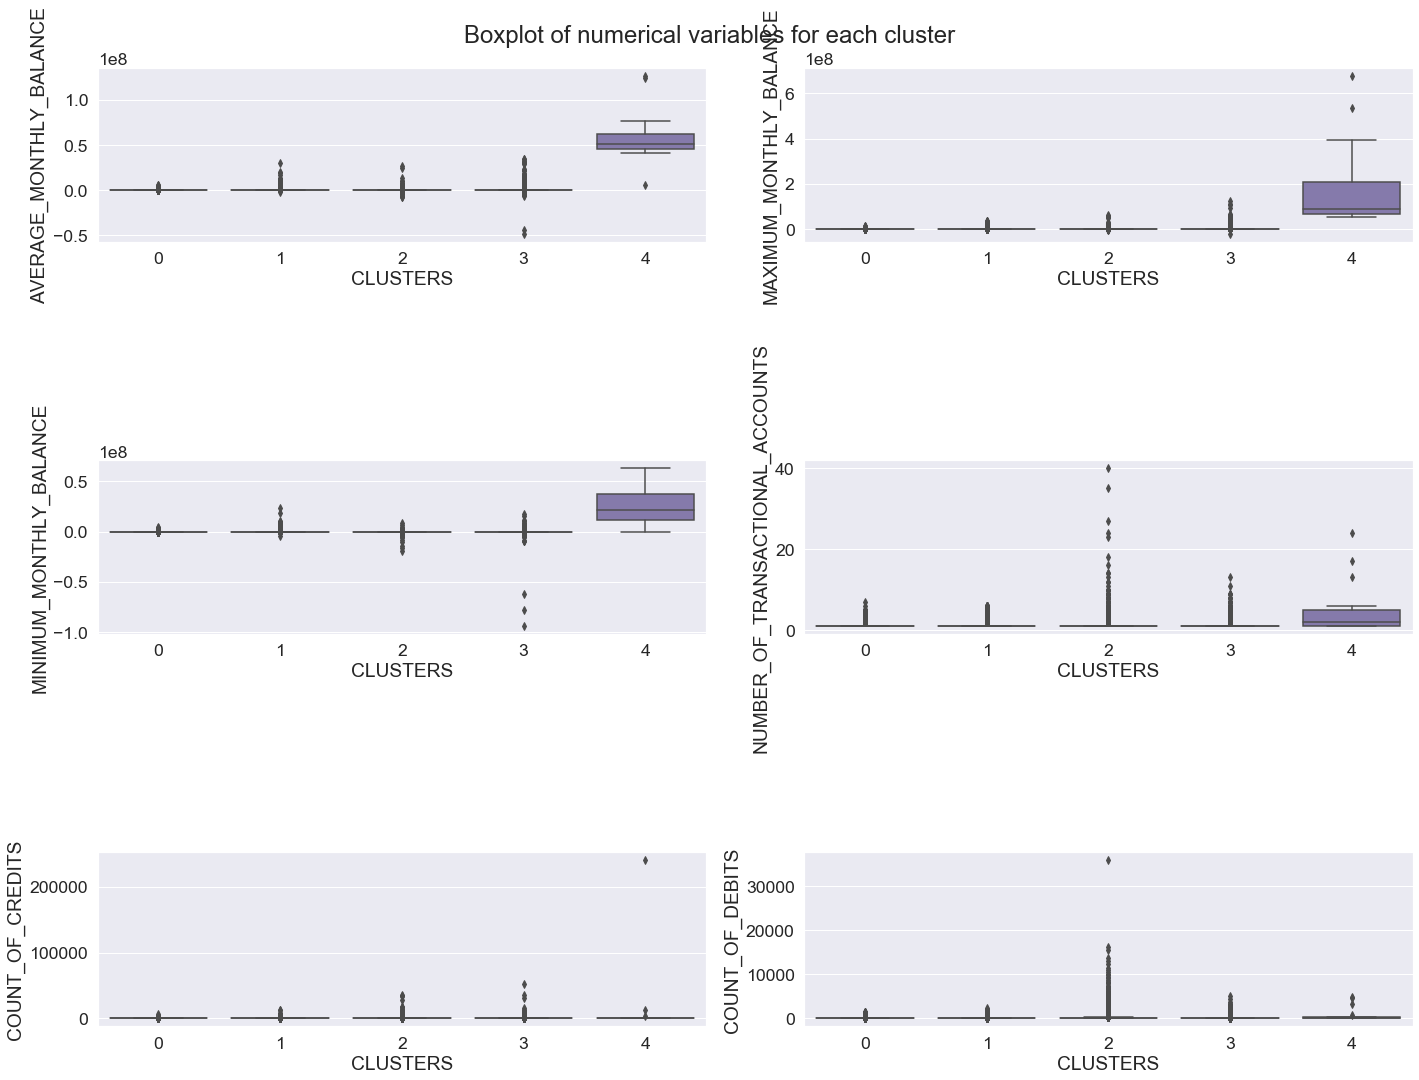

In [240]:

fig=plt.subplots(figsize=(20,20))

for i, j in enumerate(numerical):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.boxplot(y=data2[j],x=data2['CLUSTERS'])
    sns.set(font_scale=1.6)

plt.tight_layout(0.9)
plt.suptitle("Boxplot of numerical variables for each cluster", size=24)
plt.subplots_adjust(top=0.95)

In [241]:
data2[numerical+['CLUSTERS']].groupby(['CLUSTERS']).describe().T

CLUSTERS                                           0             1  \
AVERAGE_MONTHLY_BALANCE          count     44,551.00     90,475.00   
                                 mean      17,504.84     50,246.83   
                                 std      109,517.12    303,491.85   
                                 min     -161,432.89 -2,523,431.69   
                                 25%          145.16        162.78   
                                 50%          378.75      1,376.94   
                                 75%        2,879.65     13,900.19   
                                 max    5,842,169.56 30,221,044.14   
MAXIMUM_MONTHLY_BALANCE          count     44,551.00     90,475.00   
                                 mean      48,400.53    118,889.21   
                                 std      230,692.26    569,420.78   
                                 min     -146,991.20   -267,359.78   
                                 25%        1,670.50        500.82   
                                 50%        8,000.00     11,250.32   
                                 75%       18,974.01     57,892.90   
                                 max   12,978,071.66 36,963,562.50   
MINIMUM_MONTHLY_BALANCE          count     44,551.00     90,475.00   
                                 mean       7,934.85     24,484.11   
                                 std       74,662.20    207,426.38   
                                 min     -163,649.52 -4,674,627.60   
                                 25%            0.00          2.64   
                                 50%            0.61         59.33   
                                 75%           79.40        703.91   
                                 max    4,078,926.64 23,754,872.50   
NUMBER_OF_TRANSACTIONAL_ACCOUNTS count     44,551.00     90,475.00   
                                 mean           1.05          1.07   
                                 std            0.26          0.31   
                                 min            1.00          1.00   
                                 25%            1.00          1.00   
                                 50%            1.00          1.00   
                                 75%            1.00          1.00   
                                 max            7.00          6.00   
COUNT_OF_CREDITS                 count     44,551.00     90,475.00   
                                 mean          18.51         29.19   
                                 std           67.57        132.38   
                                 min            0.00          0.00   
                                 25%            3.00          3.00   
                                 50%            4.00         10.00   
                                 75%           40.00         40.55   
                                 max        6,193.00     13,254.00   
COUNT_OF_DEBITS                  count     44,551.00     90,475.00   
                                 mean          30.16         43.53   
                                 std           56.67         78.76   
                                 min            0.00          0.00   
                                 25%            3.00          5.00   
                                 50%            7.00         27.00   
                                 75%           50.90         50.90   
                                 max        1,480.00      2,249.00   

CLUSTERS                                            2              3  \
AVERAGE_MONTHLY_BALANCE          count      18,033.00      33,342.00   
                                 mean       42,302.28      73,505.44   
                                 std       377,156.75     763,771.97   
                                 min    -7,912,758.02 -48,706,665.39   
                                 25%           802.11         100.00   
                                 50%         3,816.09         968.65   
                                 75%        20,795.79       9,988

#### Categorical features for clusters(Distribution)

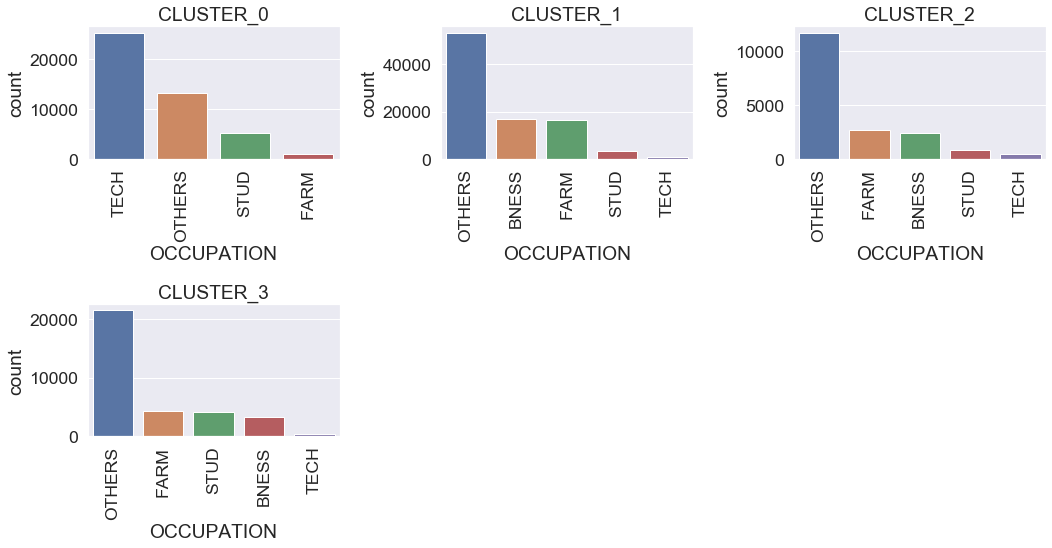

In [242]:
plt.figure(figsize = (15,8)) 

plt.subplot(2,3,1) 
plt.title('CLUSTER_0') 
sns.countplot(data2_0['OCCUPATION'], order = data2_0['OCCUPATION'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,2) 
plt.title('CLUSTER_1') 
sns.countplot(data2_1['OCCUPATION'], order = data2_1['OCCUPATION'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,3) 
plt.title('CLUSTER_2') 
sns.countplot(data2_2['OCCUPATION'], order = data2_2['OCCUPATION'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,4) 
plt.title('CLUSTER_3') 
sns.countplot(data2_3['OCCUPATION'], order = data2_3['OCCUPATION'].value_counts().index) 
plt.xticks(rotation=90)

# plt.subplot(2,3,5) 
# plt.title('CLUSTER_4') 
# sns.countplot(data2_4['OCCUPATION'], order = data2_4['OCCUPATION'].value_counts().index) 
# plt.xticks(rotation=90)

# plt.subplot(2,3,6) 
# plt.title('CLUSTER_5') 
# sns.countplot(data2_5['OCCUPATION'], order = data2_5['OCCUPATION'].value_counts().index) 
# plt.xticks(rotation=90)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [243]:
loans = data2.groupby(['CLUSTERS','HAS_LOAN'])[['CIF_ID']].count()
loans['RATE'] = loans/loans.groupby(level=0).sum()
loans.reset_index(inplace = True)

pd.pivot_table(loans, values= 'RATE',
                     index=['CLUSTERS'],
                     columns=['HAS_LOAN']).fillna(0).style.highlight_max(color = 'lightgreen', axis = 1).format("{:.2%}")


HAS_LOAN,No,Yes
CLUSTERS,,
0,100.00%,0.00%
1,100.00%,0.00%
2,0.74%,99.26%
3,99.13%,0.87%
4,100.00%,0.00%


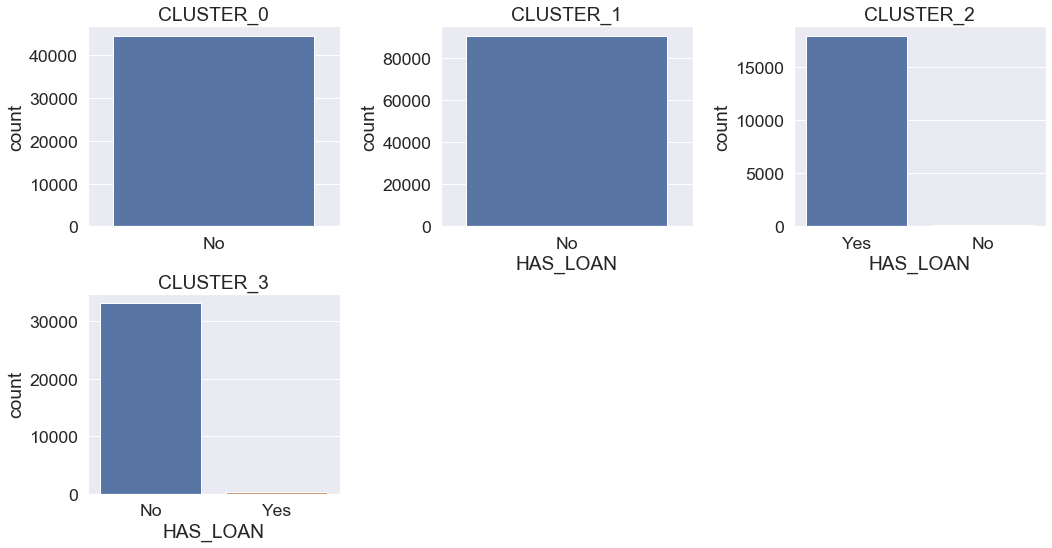

In [244]:
plt.figure(figsize = (15,8)) 

plt.subplot(2,3,1) 
plt.title('CLUSTER_0') 
sns.countplot(data2_0['HAS_LOAN'], order = data2_0['HAS_LOAN'].value_counts().index) 
plt.xlabel(None)

plt.subplot(2,3,2) 
plt.title('CLUSTER_1') 
sns.countplot(data2_1['HAS_LOAN'], order = data2_1['HAS_LOAN'].value_counts().index) 

plt.subplot(2,3,3) 
plt.title('CLUSTER_2') 
sns.countplot(data2_2['HAS_LOAN'], order = data2_2['HAS_LOAN'].value_counts().index) 

plt.subplot(2,3,4) 
plt.title('CLUSTER_3') 
sns.countplot(data2_3['HAS_LOAN'], order = data2_3['HAS_LOAN'].value_counts().index) 

# plt.subplot(2,3,5) 
# plt.title('CLUSTER_4') 
# sns.countplot(data2_4['HAS_LOAN'], order = data2_4['HAS_LOAN'].value_counts().index) 

# plt.subplot(2,3,6) 
# plt.title('CLUSTER_5') 
# sns.countplot(data2_5['HAS_LOAN'], order = data2_5['HAS_LOAN'].value_counts().index) 

plt.tight_layout()
plt.show()


In [245]:
g = data2.groupby(['CLUSTERS','GENDER'])[['CIF_ID']].count()
g['RATE'] = g/g.groupby(level=0).sum()
g.reset_index(inplace = True)

pd.pivot_table(g, values= 'RATE',
                     index=['CLUSTERS'],
                     columns=['GENDER']).fillna(0).style.highlight_max(color = 'lightgreen', axis = 1).format("{:.2%}")

GENDER,F,M,UNKNOWN
CLUSTERS,,,
0,41.89%,57.85%,0.27%
1,46.99%,52.70%,0.31%
2,34.28%,64.85%,0.87%
3,28.25%,45.82%,25.93%
4,5.88%,23.53%,70.59%


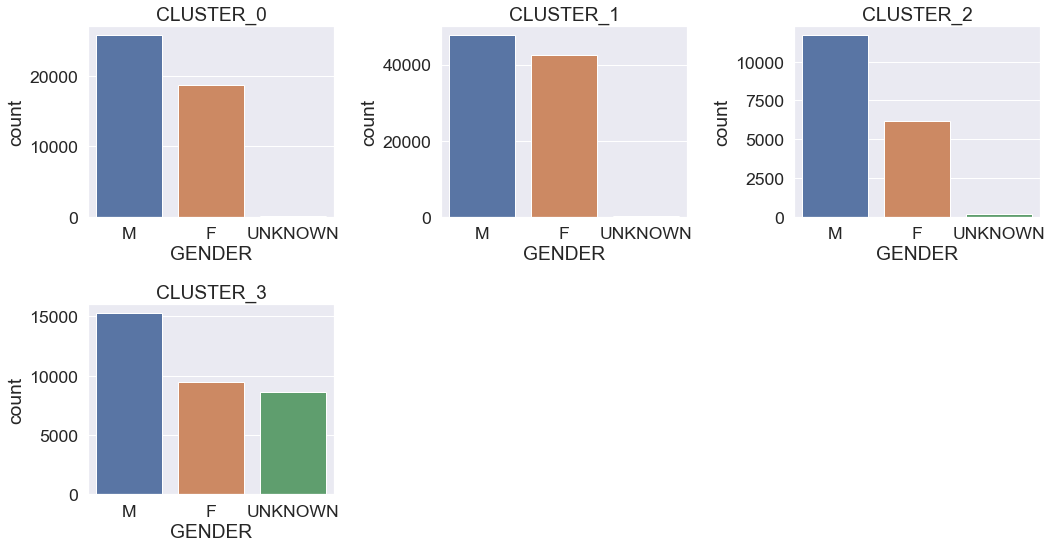

In [246]:
plt.figure(figsize = (15,8)) 

plt.subplot(2,3,1) 
plt.title('CLUSTER_0') 
sns.countplot(data2_0['GENDER'], order = data2_0['GENDER'].value_counts().index) 

plt.subplot(2,3,2) 
plt.title('CLUSTER_1') 
sns.countplot(data2_1['GENDER'], order = data2_1['GENDER'].value_counts().index) 

plt.subplot(2,3,3) 
plt.title('CLUSTER_2') 
sns.countplot(data2_2['GENDER'], order = data2_2['GENDER'].value_counts().index) 

plt.subplot(2,3,4) 
plt.title('CLUSTER_3') 
sns.countplot(data2_3['GENDER'], order = data2_3['GENDER'].value_counts().index) 

# plt.subplot(2,3,5) 
# plt.title('CLUSTER_4') 
# sns.countplot(data2_4['GENDER'], order = data2_4['GENDER'].value_counts().index) 

# plt.subplot(2,3,6) 
# plt.title('CLUSTER_5') 
# sns.countplot(data2_5['GENDER'], order = data2_5['GENDER'].value_counts().index) 

plt.tight_layout()
plt.show()


In [247]:
sc = data2.groupby(['CLUSTERS','SEGMENTATION_CLASS'])[['CIF_ID']].count()
sc['RATE'] = sc/sc.groupby(level=0).sum()
sc.reset_index(inplace = True)

pd.pivot_table(sc, values= 'RATE',
                     index=['CLUSTERS'],
                     columns=['SEGMENTATION_CLASS'])\
    .fillna(0).style.highlight_max(color = 'lightgreen', axis = 1).format("{:.2%}")

SEGMENTATION_CLASS,AGRIC,BUSINESS,CONSM,CORPT,INSTIT,MICRO,OTHERS,PUBLI,RETAIL,SME
CLUSTERS,,,,,,,,,,
0,0.03%,0.11%,1.02%,0.06%,0.00%,26.51%,0.08%,0.00%,71.67%,0.52%
1,0.02%,0.11%,0.81%,0.00%,0.00%,3.71%,0.15%,0.00%,94.74%,0.45%
2,0.99%,5.61%,4.15%,0.10%,0.01%,2.82%,0.03%,0.00%,86.15%,0.15%
3,10.49%,23.13%,45.05%,2.09%,0.79%,15.87%,0.04%,0.06%,2.17%,0.31%
4,0.00%,47.06%,0.00%,11.76%,0.00%,0.00%,0.00%,0.00%,29.41%,11.76%


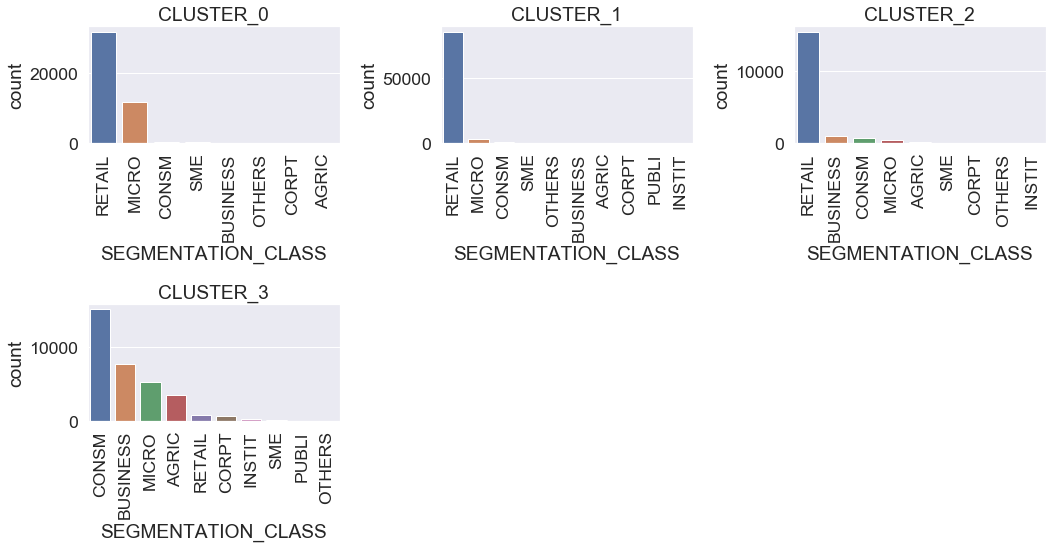

In [248]:
plt.figure(figsize = (15,8)) 

plt.subplot(2,3,1) 
plt.title('CLUSTER_0') 
sns.countplot(data2_0['SEGMENTATION_CLASS'], order = data2_0['SEGMENTATION_CLASS'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,2) 
plt.title('CLUSTER_1') 
sns.countplot(data2_1['SEGMENTATION_CLASS'], order = data2_1['SEGMENTATION_CLASS'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,3) 
plt.title('CLUSTER_2') 
sns.countplot(data2_2['SEGMENTATION_CLASS'], order = data2_2['SEGMENTATION_CLASS'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,4) 
plt.title('CLUSTER_3') 
sns.countplot(data2_3['SEGMENTATION_CLASS'], order = data2_3['SEGMENTATION_CLASS'].value_counts().index) 
plt.xticks(rotation=90)

# plt.subplot(2,3,5) 
# plt.title('CLUSTER_4') 
# sns.countplot(data2_4['SEGMENTATION_CLASS'], order = data2_4['SEGMENTATION_CLASS'].value_counts().index) 
# plt.xticks(rotation=90)

# plt.subplot(2,3,6) 
# plt.title('CLUSTER_5') 
# sns.countplot(data2_5['SEGMENTATION_CLASS'], order = data2_5['SEGMENTATION_CLASS'].value_counts().index) 
# plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [249]:
r = data2.groupby(['CLUSTERS','REGION'])[['CIF_ID']].count()
r['RATE'] = r/r.groupby(level=0).sum()
r.reset_index(inplace = True)

pd.pivot_table(r, values= 'RATE',
                     index=['CLUSTERS'],
                     columns=['REGION']).fillna(0).style.highlight_max(color = 'lightgreen', axis = 1).format("{:.2%}")

REGION,CEN,COA,EAS,NAI,NOR,NYA,OTHER,RIF,UNKNOWN,WES
CLUSTERS,,,,,,,,,,
0,0.61%,0.22%,1.79%,2.14%,0.47%,6.68%,34.94%,18.23%,24.37%,10.54%
1,24.32%,5.46%,18.71%,17.39%,1.96%,7.01%,6.41%,15.70%,1.08%,1.95%
2,18.77%,5.10%,15.23%,12.29%,1.07%,10.04%,5.06%,25.87%,1.11%,5.46%
3,15.82%,5.96%,11.06%,17.77%,1.91%,9.90%,12.33%,19.62%,0.13%,5.50%
4,0.00%,5.88%,5.88%,58.82%,23.53%,0.00%,0.00%,5.88%,0.00%,0.00%


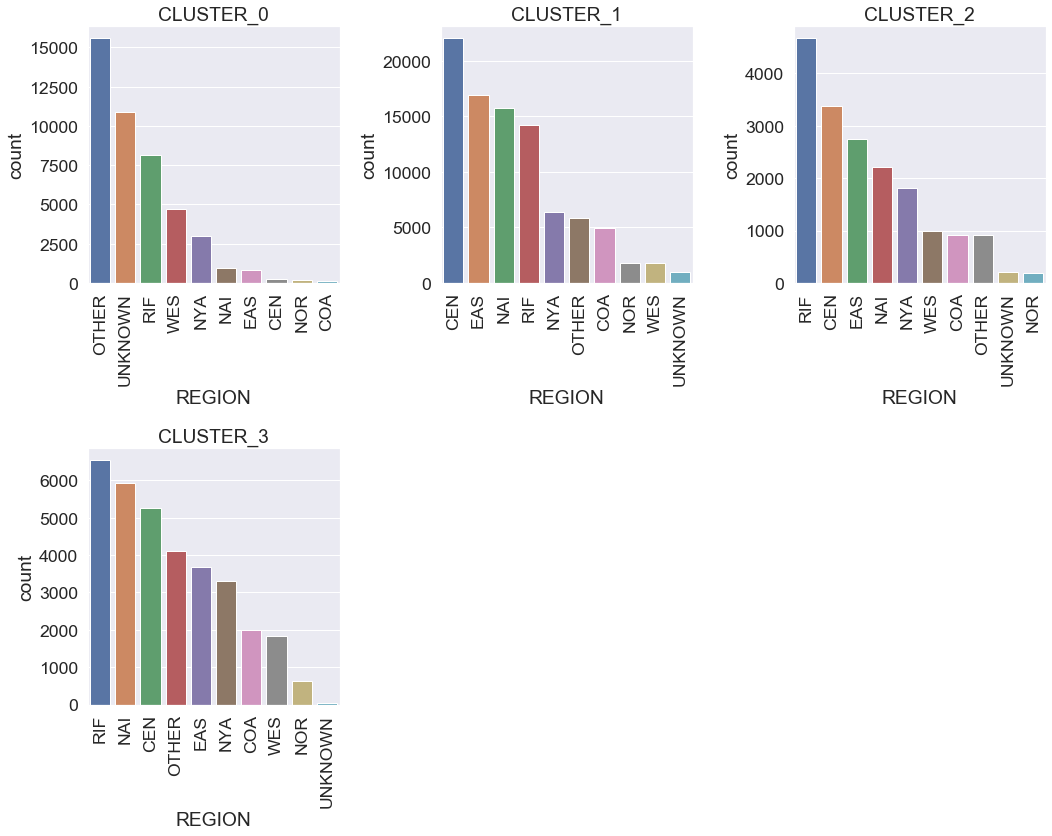

In [250]:
plt.figure(figsize = (15,12)) 

plt.subplot(2,3,1) 
plt.title('CLUSTER_0') 
sns.countplot(data2_0['REGION'], order = data2_0['REGION'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,2) 
plt.title('CLUSTER_1') 
sns.countplot(data2_1['REGION'], order = data2_1['REGION'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,3) 
plt.title('CLUSTER_2') 
sns.countplot(data2_2['REGION'], order = data2_2['REGION'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,4) 
plt.title('CLUSTER_3') 
sns.countplot(data2_3['REGION'], order = data2_3['REGION'].value_counts().index) 
plt.xticks(rotation=90)

# plt.subplot(2,3,5) 
# plt.title('CLUSTER_4') 
# sns.countplot(data2_4['REGION'], order = data2_4['REGION'].value_counts().index) 
# plt.xticks(rotation=90)

# plt.subplot(2,3,6) 
# plt.title('CLUSTER_5') 
# sns.countplot(data2_5['REGION'], order = data2_5['REGION'].value_counts().index) 
# plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


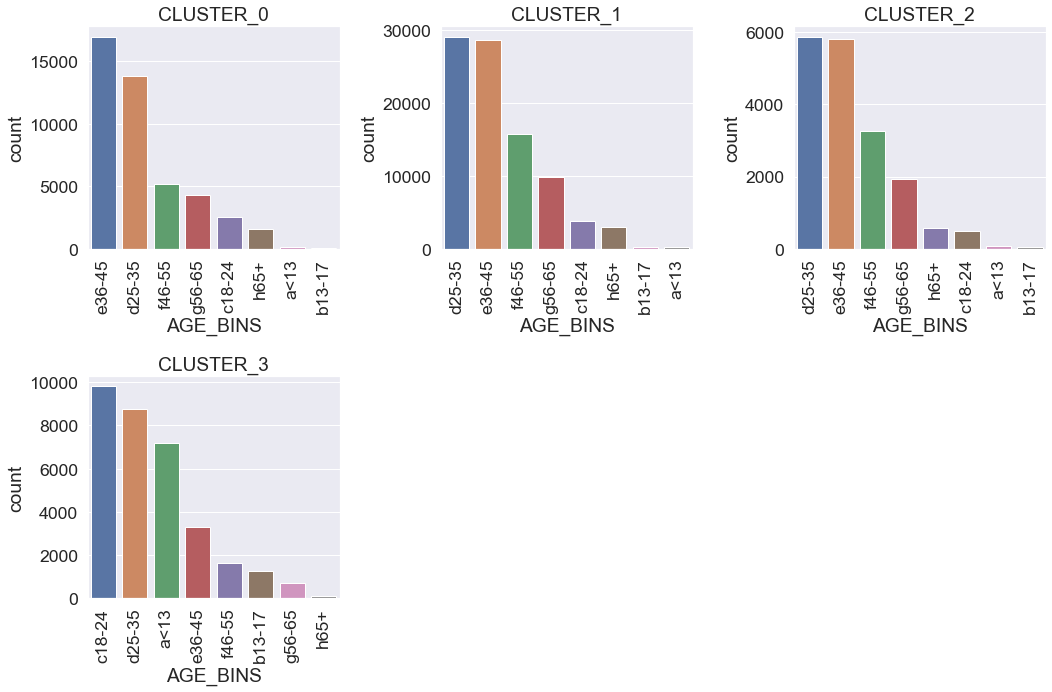

In [251]:

plt.figure(figsize = (15,10)) 

plt.subplot(2,3,1) 
plt.title('CLUSTER_0') 
sns.countplot(data2_0['AGE_BINS'], order = data2_0['AGE_BINS'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,2) 
plt.title('CLUSTER_1') 
sns.countplot(data2_1['AGE_BINS'], order = data2_1['AGE_BINS'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,3) 
plt.title('CLUSTER_2') 
sns.countplot(data2_2['AGE_BINS'], order = data2_2['AGE_BINS'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,4) 
plt.title('CLUSTER_3') 
sns.countplot(data2_3['AGE_BINS'], order = data2_3['AGE_BINS'].value_counts().index) 
plt.xticks(rotation=90)

# plt.subplot(2,3,5) 
# plt.title('CLUSTER_4') 
# sns.countplot(data2_4['AGE_BINS'],  order = data2_4['AGE_BINS'].value_counts().index) 
# plt.xticks(rotation=90)

# plt.subplot(2,3,6) 
# plt.title('CLUSTER_5') 
# sns.countplot(data2_5['AGE_BINS'],  order = data2_5['AGE_BINS'].value_counts().index) 
# plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

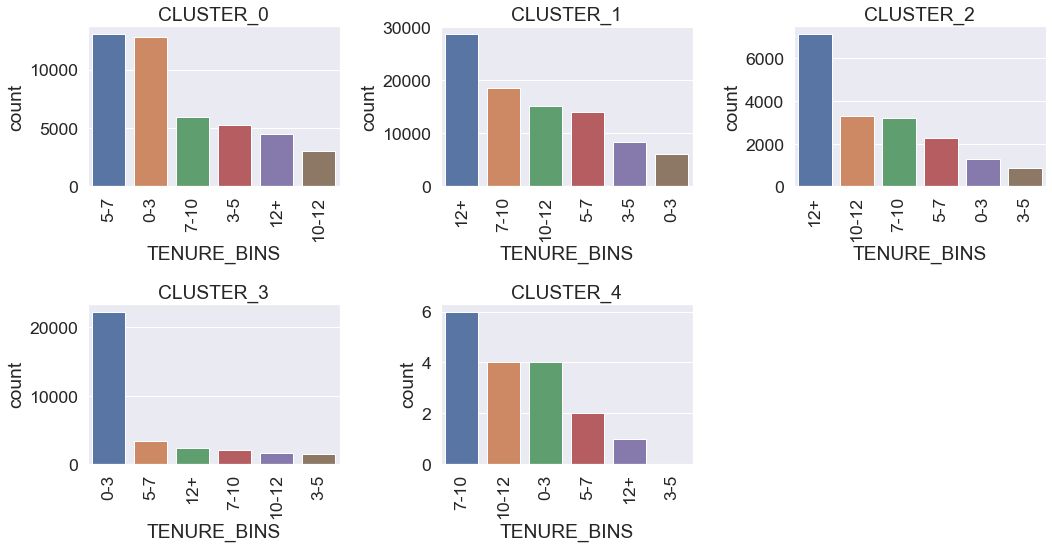

In [252]:
plt.figure(figsize = (15,8)) 

plt.subplot(2,3,1) 
plt.title('CLUSTER_0') 
sns.countplot(data2_0['TENURE_BINS'], order = data2_0['TENURE_BINS'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,2) 
plt.title('CLUSTER_1') 
sns.countplot(data2_1['TENURE_BINS'], order = data2_1['TENURE_BINS'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,3) 
plt.title('CLUSTER_2') 
sns.countplot(data2_2['TENURE_BINS'], order = data2_2['TENURE_BINS'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,4) 
plt.title('CLUSTER_3') 
sns.countplot(data2_3['TENURE_BINS'], order = data2_3['TENURE_BINS'].value_counts().index) 
plt.xticks(rotation=90)

plt.subplot(2,3,5) 
plt.title('CLUSTER_4') 
sns.countplot(data2_4['TENURE_BINS'], order = data2_4['TENURE_BINS'].value_counts().index) 
plt.xticks(rotation=90)

# plt.subplot(2,3,6) 
# plt.title('CLUSTER_5') 
# sns.countplot(data2_5['TENURE_BINS'], order = data2_5['TENURE_BINS'].value_counts().index) 
# plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
